Clone the correct branch of the ArcRasterRescue repository from GitHub, and compile the executable.

Install missing package dependencies.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas geopandas numpy seaborn rasterio ipyparallel swifter distance pyarrow openpyxl

In [2]:
!{sys.executable} -m pip install git+https://github.com/eth-cscs/ipcluster_magic

  Cloning https://github.com/eth-cscs/ipcluster_magic to /media/data/tmp/pip-req-build-9blk48eq
  Running command git clone -q https://github.com/eth-cscs/ipcluster_magic /media/data/tmp/pip-req-build-9blk48eq
  Created wheel for ipcmagic-cscs: filename=ipcmagic_cscs-1.0.3-py3-none-any.whl size=4390 sha256=696281ebabef792a00b340473c218ad9c08252174ba06c9876116de941603dac
  Stored in directory: /media/data/tmp/pip-ephem-wheel-cache-mxkha4i3/wheels/4a/d6/b0/af3067697e29ed581b5bdb9e1df9091c99ffaccf43a13ec45a
Successfully built ipcmagic-cscs


Import required packages.

In [3]:
import os
import matplotlib.pyplot as plt
#import datatable
import pandas as pd
import geopandas as gpd
import pickle
import seaborn as sns
from shapely.ops import unary_union, Polygon
import numpy as np
from numpy.polynomial import Polynomial
import csv
from scipy.optimize import curve_fit
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.io import MemoryFile
#from geocube.api.core import make_geocube
import subprocess
import shlex
from rasterio.plot import show, show_hist
import warnings
#from pympler import asizeof
import ipcmagic
import ipyparallel as ipp
#import mapply
import swifter
import fiona
import affine
from osgeo import gdal
import glob
import operator
import distance
from scipy.optimize import curve_fit as _curve_fit
from functools import partial, wraps
import itertools

Set global notebook parameters.

In [4]:
pd.set_option('display.max_rows', 300) # bump this parameter up if you want to see more table rows
pd.set_option('display.max_columns', 30) # bump this parameter up if you want to see more table rows

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
%config Completer.use_jedi = False # patch autocomplete bug

Launch and set up `ipyparallel` cluster on the VM. We will deploy parallel processing jobs to this cluster at various stages in the process to speed up processing (take advantage of 16 cores available on the host).

In [5]:
#%ipcluster --help
%ipcluster start -n 16
rc = ipp.Client()
lbview = rc.load_balanced_view()

  0%|          | 0/16 [00:00<?, ?engine/s]

Define path strings and such.

In [6]:
vri_vclr1p_path = '../data/bc/vri/2019/VEG_COMP_LYR_R1_POLY.gdb'
ria_stands_path = './data/veg_comp_lyr_r1_poly-ria.shp'
tsa_boundaries_path = '../data/bc/tsa/FADM_TSA.gdb/'
ria_maptiles_path = 'ria_maptiles.csv'
vdyp_input_pandl_path = '../data/bc/vri/2019/VEG_COMP_VDYP7_INPUT_POLY_AND_LAYER_2019.gdb'

site_prod_bc_gdb_path = './data/Site_Prod_BC.gdb/' # ESRI File Geodatabase containing 22 species-wise site productivity raster layers

tsa_boundaries_feather_path = './data/tsa_boundaries.feather'
ria_vri_vclr1p_checkpoint1_feather_path = './data/ria_vri_vclr1p_checkpoint1.feather'
ria_vri_vclr1p_checkpoint2_feather_path = './data/ria_vri_vclr1p_checkpoint2.feather'
ria_vri_vclr1p_checkpoint3_feather_path = './data/ria_vri_vclr1p_checkpoint3.feather'
ria_vri_vclr1p_checkpoint4_feather_path = './data/ria_vri_vclr1p_checkpoint4.feather'
ria_vri_vclr1p_checkpoint5_feather_path = './data/ria_vri_vclr1p_checkpoint5.feather'
ria_vri_vclr1p_checkpoint6_feather_path = './data/ria_vri_vclr1p_checkpoint6.feather'
ria_vri_vclr1p_checkpoint7_feather_path = './data/ria_vri_vclr1p_checkpoint7.feather'
ria_vri_vclr1p_checkpoint8_feather_path = './data/ria_vri_vclr1p_checkpoint8.feather'
vri_vclr1p_categorical_columns_path = './data/vri_vclr1p_categorical_columns'
ria_vclr1p_feature_tif_path = './data/ria_vclr1p_feature_raster.tif'

arc_raster_rescue_exe_path = 'ArcRasterRescue/build/arc_raster_rescue.exe'
siteprod_gdb_path = '../data/Site_Prod_BC.gdb/'
siteprod_tmpexport_tif_path_prefix = './data/site_prod_bc_'
siteprod_tif_path = './data/siteprod.tif'

vdyp_ply_feather_path = './data/vdyp_ply.feather'
vdyp_lyr_feather_path = './data/vdyp_lyr.feather'
vdyp_results_tsa_pickle_path_prefix = './data/vdyp_results-tsa'
vdyp_results_pickle_path = './data/vdyp_results.pkl'
vdyp_curves_smooth_tsa_feather_path_prefix = './data/vdyp_curves_smooth-tsa'
vdyp_curves_smooth_feather_path = './data/vdyp_curves_smooth.feather'

tipsy_params_path_prefix = './data/tipsy_params_tsa'

#ria_tsas = ['08', '16', '24', '40', '41']
ria_tsas = ['25']
si_levels = ['L', 'M', 'H']

raster_pxw = raster_pxh = 100

tipsy_params_columns = [line.strip() for line in open('./data/tipsy_params_columns').readlines()]

Define lists grouping species codes by genus.

In [7]:
species_spruce = ['S', 'SB', 'SE', 'SN', 'SS', 'SW', 'SX', 'SXE', 'SXL', 'SXW']
species_pine = ['P', 'PA', 'PJ', 'PL', 'PLC', 'PLI', 'PM']
species_fir = ['B', 'BA', 'BB', 'BG', 'BL', 'BM', 'BP']
species_larch = ['L', 'LA', 'LS', 'LT', 'LW']
species_cedar = ['C', 'CW']
species_hemlock = ['HM', 'HWI', 'HW']
species_douglasfir = ['F', 'FD', 'FDC', 'FDI']

species_aspen = ['AC', 'ACB', 'ACT', 'AD', 'AT', 'AX']
species_birch = ['E', 'EA', 'EB', 'EE', 'EP', 'EW', 'EXP']
species_willow = ['W','WA', 'WB', 'WD', 'WP', 'WS']
species_alder = ['D', 'DR']
species_cherry = ['V']
species_dogwood = ['GP']
species_oak = ['Q']
species_maple = ['M', 'MB', 'MV']

Download and compile ArcRasterRescue package. We will use this later to extract raster data from proprietary ESRI File Geodatabase.

In [8]:
if not os.path.isfile(arc_raster_rescue_exe_path):
    !git clone https://github.com/gparadis/ArcRasterRescue.git
    !cd ArcRasterRescue; git checkout bug-fix_transform
    !mkdir ArcRasterRescue/build
    !cd ArcRasterRescue/build; cmake -DCMAKE_BUILD_TYPE=RelWithDebInfo ..; make

Load TSA boundary data for the 5 TSAs in the RIA landbase (TSAs 08, 16, 24, 40, 41) and compile a single polygon defining RIA landbase extent. We simplify the boundary geometry for each TSA (preserving topology). Cache a copy of result to a feather file (can later be imported to speed up processing).

In [9]:
import_tsa_boundaries_data = 0
if import_tsa_boundaries_data:
    tsa_boundaries = gpd.read_file(tsa_boundaries_path)
    tsa_boundaries = tsa_boundaries[['TSA_NUMBER', 'geometry']].loc[tsa_boundaries.TSA_NUMBER.isin(ria_tsas)].dissolve(by='TSA_NUMBER')
    tsa_boundaries['geometry'] = tsa_boundaries.geometry.simplify(tolerance=1000, preserve_topology=True)
    tsa_boundaries.to_feather(tsa_boundaries_feather_path)
else:
    tsa_boundaries = gpd.read_feather(tsa_boundaries_feather_path)

#tsa_extent_all = Polygon(unary_union(list(tsa_boundaries.geometry.values)).exterior) 

Load VRI features (_vegetation composite layer and R1 polygon_ dataset), masked to RIA landbase extent. Cache a copy of result to a feather file (can later be imported to speed up processing).

In [10]:
%%time
import_vri_vclr1p_data = 0 # set to False to use cached data 
if import_vri_vclr1p_data:
    print('loading VRI data from source')
    def load_vri_vclr1p(vri_vclr1p_path, tsa_code, tsa_mask, ignore_geometry=False):
        import geopandas as gpd # local import required to play nice with ipp engines
        result = gpd.read_file(vri_vclr1p_path, 
                               mask=tsa_mask,
                               ignore_geometry=ignore_geometry)
        result['tsa_code'] = tsa_code
        return result
    tsa_gdfs = lbview.map_async(load_vri_vclr1p, 
                                [vri_vclr1p_path for tsa in ria_tsas],
                                ria_tsas, 
                                [tsa_boundaries.loc[tsa].geometry for tsa in ria_tsas],
                                ordered=True)
    rc.wait_interactive()
    ria_vri_vclr1p = pd.concat(tsa_gdfs, axis=0, ignore_index=True)
    ria_vri_vclr1p.to_feather(ria_vri_vclr1p_checkpoint1_feather_path)
else:
    print('loading VRI data from checkpoint1 feather')
    ria_vri_vclr1p = gpd.read_feather(ria_vri_vclr1p_checkpoint1_feather_path)

f = ria_vri_vclr1p

loading VRI data from checkpoint1 feather
CPU times: user 2.68 s, sys: 893 ms, total: 3.57 s
Wall time: 3.13 s


Extract site productivity raster data from proprietary ESRI File Geodatabase, and export it to species-wise GeoTIFF layers, patch the missing CRS metadata, and stack everything into a single multi-band GeoTIFF. 

In [11]:
# run ArcRasterRescue on siteprod ESRI File GeoDatabase raster dataset
result = subprocess.run(shlex.split('%s %s' % (arc_raster_rescue_exe_path, siteprod_gdb_path)), capture_output=True)
# map layer indices to layer species codes
siteprod_layerspecies =  {int(i):vv[10:].upper() 
                          for i, vv in [v.strip().split(' ') 
                                        for v in result.stdout.decode().split('\n')[1:] if v]}
siteprod_specieslayer =  {vv[10:].upper():int(i) 
                          for i, vv in [v.strip().split(' ') 
                                        for v in result.stdout.decode().split('\n')[1:] if v]}

if not os.path.isfile(siteprod_tif_path):

    # export species-wise raster layers to 22 GeoTIFFs
    print('Extracting siteprod raster data from ESRI File Geodatabase...')
    for i, species in siteprod_layerspecies.items():
        print('... processing species', species)
        args = '%s %s %i %s' % (arc_raster_rescue_exe_path, 
                                siteprod_gdb_path, 
                                i, 
                                '%s%s.tif' % (siteprod_tmpexport_tif_path_prefix, species))
        subprocess.run(shlex.split(args))

    # stack species-wise raster layers into a single multi-band GeoTIFF
    file_list = sorted(glob.glob('%s*.tif' % siteprod_tmpexport_tif_path_prefix))
    with rio.open(file_list[0]) as src: # patch with missing CRS metadata
        meta = src.meta
        meta.update(count=len(file_list), 
                    compress='lzw', 
                    crs=rio.crs.CRS({"init": "epsg:3005"})) # BC Albers equal area geographic projection

    with rio.open(siteprod_tif_path, 'w', **meta) as dst:
        print('\nStacking siteprod raster data into a single multiband GeoTIFF file...')
        for id, layer in enumerate(file_list, start=1):
            print('... processing species', siteprod_layerspecies[id-1])
            with rio.open(layer) as src:
                dst.write_band(id, src.read(1))
            os.remove(layer) # delete intermediate GeoTIFF (not needed anymore)

Define a species code lookup dict to map VRI species codes to one of the 22 siteprod species codes. We built the key list for this dict by compiling unique values from the `SPECIES_CD_1` column in the VRI feature dataset, and netting out the 22 siteprod species codes. Assignments with question mark comments may need to be revisited. If this project is ported to a different landbase, this list would likely need to be expanded (we can eventually just build a BC-wide species code map from the unfiltered VRI dataset).

In [12]:
def siteprod_species_lookup(s):
    spp = {'AC': 'AT',
           'PLI': 'PL',
           'FDI': 'FD',
           'S': 'SW',
           'SXL': 'SX',
           'ACT': 'AT',
           'E': 'EP',
           'P': 'PL',
           'EA': 'EP',
           'SXW': 'SX',
           'W': 'EP', # ?
           'T': 'LT', # ?
           'L': 'LT',
           'B': 'BL',
           'ACB': 'AT',
           'PJ': 'PL', # ?
           'WS': 'EP',
           'LA':'LT',
           'AX':'AT',
           'BB':'BL',
           'H':'HW', 
           'BM':'BL',
           'V':'DR',
           'F':'FD',
           'C':'CW',
           'XC':'PL',
           'XD':'SW',
           'X':'SW',
           'A':'AT',
           'D':'DR',
           'Z':'SW',
           'Q':'AT',
           'Y':'YC',
           'R':'DR',
           'G':'DR'} # ?
    try:
        result = spp[s]
    except:
        try:
            result = spp[s[0]]
        except:
            print(s)
            assert False # bad species code
    return result
    
species_list = list(set().union(*[ria_vri_vclr1p['SPECIES_CD_%i' % i].unique() for i in range(1, 7)]))
species_list = [s for s in species_list if s is not None]

Clean and filter VRI feature dataset. This includes replacing null data values in certain columns with specific non-null values ('X' or 0, depending on field type) to ensure that data processing logic works correctly in downstream steps. 

In earlier versions of this code we cast some columns to `category` data type (in an attempt to reduce memory footprint and maybe speeds up some processing), but this proved to be more trouble than it was worth and that code is commented out in the current version.

Then, for each feature in the VRI dataaset, extract mean SI data from the pixels in the siteprod raster layer corresponding the leading species. This step is computationally intensive (takes about 30 minutes to run), so this is a good time to go for a walk.

Cache a copy of result to a feather file (can later be imported to speed up processing).

In [13]:
process_checkpoint2 = 0
if process_checkpoint2:
    for i in range(1, 7):
        f['SPECIES_CD_%i' % i].fillna('X', inplace=True)
        f['SPECIES_PCT_%i' % i].fillna(0, inplace=True)
    f['SOIL_NUTRIENT_REGIME'].fillna('X', inplace=True)
    f['SOIL_MOISTURE_REGIME_1'].fillna('X', inplace=True)
    f['SITE_POSITION_MESO'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_3'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_4'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_5'].fillna('X', inplace=True)
    f['BEC_VARIANT'].fillna('X', inplace=True)
    f['LIVE_STAND_VOLUME_125'].fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP1_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP2_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP3_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP4_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP5_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP6_125.fillna(0, inplace=True)
    f = f[f.BCLCS_LEVEL_2 == 'T'] # implies f.BCLCS_LEVEL_1 == 'V'
    #f = f[f.BCLCS_LEVEL_5 != 'OP']
    f = f[f.NON_PRODUCTIVE_CD != None]
    f = f[f.FOR_MGMT_LAND_BASE_IND == 'Y']
    f = f[~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])]
    f = f[f.PROJ_AGE_1 >= 30]
    f = f[f.BASAL_AREA >= 5]
    f = f[f.LIVE_STAND_VOLUME_125 >= 1]
    f.shape
    #vri_vclr1p_categorical_columns = open(vri_vclr1p_categorical_columns_path).read().split('\n')
    #for c in vri_vclr1p_categorical_columns: 
    #    f[c] = f[c].astype('category')
    with rio.open(siteprod_tif_path) as src:
        def mean_siteprod(r):
            a, _ = mask(src, r.geometry, crop=True)
            s = r.SPECIES_CD_1 
            s = s if s in siteprod_specieslayer else siteprod_species_lookup(s)
            i = siteprod_specieslayer[s]
            aa = a[i]
            return np.mean(aa[aa > 0])
        f['siteprod'] = f.swifter.apply(mean_siteprod, axis=1)
    f.to_feather(ria_vri_vclr1p_checkpoint2_feather_path)
else:
    print('loading VRI data from checkpoint2 feather')
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint2_feather_path)

loading VRI data from checkpoint2 feather


VRI data includes merchantable growing stock (per ha) and species codes for the top 7 species in each stand. We recompile the volume data into species-wise columns (using species codes from `species_list`, defined earlier). This makes the table bigger (lots of null values, as only up to 7 species volume columns will have data), but makes the processing logic simpler and more stable later on.

Cache a copy of result to a feather file (can later be imported to speed up processing).

In [14]:
f.reset_index(inplace=True)

In [15]:
process_checkpoint3 = 0
if process_checkpoint3:
    def compile_species_vol(df, species):
        import swifter
        return df.swifter.apply(lambda r: sum(r['LIVE_VOL_PER_HA_SPP%i_125' % i] 
                                              for i in range(1, 7)
                                              if r['SPECIES_CD_%i' % i] == species), axis=1)
    cols = list(itertools.chain.from_iterable(['LIVE_VOL_PER_HA_SPP%i_125' % i]+['SPECIES_CD_%i' % i] for i in range(1, 7)))    
    f_ = f[cols]
    result = lbview.map_async(compile_species_vol, 
                              [f_]*len(species_list), 
                              species_list, 
                              ordered=True)
    rc.wait_interactive()
    
    for i, species in enumerate(species_list):
        print('compiling species', species)
        f['live_vol_per_ha_125_%s' % species] = result[i]
    f.to_feather(ria_vri_vclr1p_checkpoint3_feather_path)
else:
    print('loading VRI data from checkpoint3 feather')
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint3_feather_path)

loading VRI data from checkpoint3 feather


Define some utility functions that we will use later to classify VRI records.

In [16]:
def is_conif(species_code):
    # return True if species_code is coniferous species
    return species_code[:1] in ['B', 'C', 'F', 'H', 'J', 'L', 'P', 'S', 'T', 'Y']


def is_decid(species_code):
    # return True if species_code is deciduous species
    return species_code[:1] in ['A', 'D', 'E', 'G', 'M', 'Q', 'R', 'U', 'V', 'W']


def pconif(r):
    # return proportion of volume from coniferous species in record r
    return sum(r['SPECIES_PCT_%i' % i] for i in range(1, 7) if is_conif(r['SPECIES_CD_%i' % i])) / 100.


def pdecid(r):
    # return proportion of volume from deciduous species in record r
    return sum(r['SPECIES_PCT_%i' % i] for i in range(1, 7) if is_decid(r['SPECIES_CD_%i' % i])) / 100.
    

def classify_stand_cdm(r):
    # Classify stand (from VRI record r) as one of: conif (c), decid (d), or mixed (m), where
    #   c >= 80% softwood
    #   d >= 80% hardwood
    #   m otherwise
    if pconif(r) >= 0.8:
        return 'c'
    elif pdecid(r) >= 0.8:
        return 'd'
    else:
        return 'm'
    
def classify_stand_forest_type(r):
    # to (approximately) match TSA 41 TSR data package AU regeneration logic
    if pconif(r) >= 0.75:
        return 1 # pure conif
    elif pconif(r) >= 0.50:
        return 2 # conif mix
    elif pconif(r) >= 0.25:
        return 3 # decid mix
    else:
        return 4 # pure decid

Next we define a function to generate stratum codes for a given VRI record `r`. 

In standard (not lexmatch) mode, this function will generate a stratum code string including BEC zone code, leading species code, and secondary species code (if classified as a mixedwood stand according to BCLCS codes). 

In lexmatch mode, this will generate a longer stratum code string intended for lexicographic matching (used later with a clustering algorithm that finds "best match" strata based on these codes. Stratum code strings are built from the same data, but use special "lexmatch" versions of the data fields where data values have enhanced. Lexmatch field values are recompiled to a fixed width (padded with `x` character), and in the case of (primary, secondary, tertiary) species code fields the first charater (representing genus, sort of) is duplicated. These lexmatch field values are repeated (3 times for the BEC zone code, 2 times for the primary species code) within the lexmatch stratum codes to influence the relative importance of different components during matching. 

Note that we tested several alternative stratum code formulations before settling on this one, which yielded consistently good results across all 5 TSAs in the study area. In searching for a "good" stratification scheme, we were looking for relatively tight SI distribution within each stratum (indicating that the aggregated sites have a similar growth potential) and a high proportion of total area coverage in the top 15 or so strata within a given TSA (indicating that we can compile growth and yield curves for a relatively small number of strata while still covering most of the forest).   

In [17]:
def stratify_stand(r, lexmatch=False, lexmatch_fieldname_suffix='_lexmatch'):
    result = ''
    if lexmatch:
        result += 3 * r['BEC_ZONE_CODE%s' % lexmatch_fieldname_suffix]
        result += '_'
        #result += r.BCLCS_LEVEL_5
        #result += '_'
        result += 2 * r['SPECIES_CD_1%s' % lexmatch_fieldname_suffix]
        if r.BCLCS_LEVEL_4 == 'TM' and r.SPECIES_CD_2 != None:
            result += '+' + r['SPECIES_CD_2%s' % lexmatch_fieldname_suffix]
    else:
        result += r.BEC_ZONE_CODE
        result += '_'
        #result += r.BCLCS_LEVEL_5
        #result += '_'
        result += r.SPECIES_CD_1
        if r.BCLCS_LEVEL_4 == 'TM' and r.SPECIES_CD_2 != None:
            result += '+' + r.SPECIES_CD_2
    return result

Compile enhanced lexmatch fields as described above, and use the `stratify_stands` function to compile `stratum` and `stratum_lexmatch` columns.  We use the `swifter` version of the `apply` method here, which will attempt to automatically parallelize processing.

In [18]:
f['BEC_ZONE_CODE_lexmatch'] = f.BEC_ZONE_CODE.str.ljust(4, fillchar='x')
for i in range(1, 3):
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str.ljust(4, 'x')
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str[:1] + f['SPECIES_CD_%i' % i]

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

f['stratum'] = f.swifter.apply(stratify_stand, axis=1)
f['stratum_lexmatch'] = f.swifter.apply(stratify_stand_lexmatch, axis=1)

Pandas Apply:   0%|          | 0/65021 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/65021 [00:00<?, ?it/s]

In [19]:
stratum_col = 'stratum'

Compile `forest_type` column (1: softwood, 2: softwood mix, 3: hardwood mix, 4: hardwood).

In [20]:
#f['forest_type'] = f.reset_index().swifter.apply(classify_stand_forest_type, axis=1)
f['forest_type'] = f.apply(classify_stand_forest_type, axis=1)

Save checkpoint 4 stand dataframe to feather file.

In [21]:
f.to_feather(ria_vri_vclr1p_checkpoint4_feather_path)

In [132]:
if 1: # roll back if screwed up further down
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint4_feather_path)

We are done with inventory data pre-processing now. In the next part of the procedure, we define strata and analysis units (AUs) within each TSA, and generate VDYP and TIPSY yield curves for each AU. 

# Compile strata, AUs, and yield curves for each TSA

In [133]:
#f = f.reset_index().set_index('tsa_code')

Define some empty dicts to store various outputs from the following steps.

In [134]:
vdyp_curves_smooth = {}
vdyp_results = {}
tipsy_params = {}
tipsy_curves = {}
scsi_au = {}
au_scsi = {}
results = {}

In [135]:
if 0:
    def process_vdyp_out(vdyp_out, volume_flavour='Vdwb', min_age=30, max_age=300, 
                         sigma_c1=10, sigma_c2=0.4, dx_c1=0.5, dx_c2=10,
                         window=10,  skip1=0, skip2=30, maxfev=100000,
                         body_fit_func=body_fit_func, body_fit_func_bounds_func=body_fit_func_bounds_func,
                         toe_fit_func=toe_fit_func, toe_fit_func_bounds_func=toe_fit_func_bounds_func):
        vdyp_out_concat = pd.concat([v for v in vdyp_out.values() if type(v) == pd.core.frame.DataFrame])
        c = vdyp_out_concat.groupby(level='Age')[volume_flavour].median()
        c = c[c > 0]
        c = c[c.index >= min_age]
        x = c.index.values
        y = c.rolling(window=window, center=True).median().values
        x, y = x[y > 0], y[y > 0]
        x, y = x[skip1:], y[skip1:]
        #return x, y
        y_mai = pd.Series(y / x, x)
        y_mai_max_age = y_mai.idxmax()
        sigma = (np.abs(x - y_mai_max_age) + sigma_c1)**sigma_c2
        popt, pcov = curve_fit(body_fit_func, x, y, bounds=body_fit_func_bounds_func(x), maxfev=maxfev, sigma=sigma)
        x = np.array(range(1, max_age))
        y = fit_func1(x, *popt)
        dx = max(0, dx_c1 * popt[2] - dx_c2)
        print(dx, dx_c1, popt[2], dx_c2)
        x, y, (i1, popt_toe) = fill_curve_left(x, y, skip=skip2, dx=dx, maxfev=maxfev,
                                               toe_fit_func=toe_fit_func, toe_fit_func_bounds_func=toe_fit_func_bounds_func)
        print(popt_toe)
        return x, y

Define some keyword argument override values, to fine-tune curve generation for a few difficult AUs. Most AUs get processed without problems using default parameters. We found these special cases after visually inspecting output curves using default parameters, and determined the custom parameters values through "expert tuning".

In [136]:
#kwarg_overrides = {'08':{('BWBS_SB', 'H'):{'skip1':30},
#                         ('BWBS_S', 'L'):{'skip1':50},
#                         ('SWB_S', 'L'):{'skip1':30},
#                         ('BWBS_AT', 'H'):{'skip1':30}},
#                   '16':{('SWB_SX', 'L'):{'skip1':30}},
#                   '24':{('ESSF_BL', 'L'):{'skip1':30}},
#                   '40':{('BWBS_SX', 'L'):{'skip1':30},
#                         ('SWB_SX', 'L'):{'skip1':60, 'dx_c1':1., 'dx_c2':0.}},
#                   '41':{('ESSF_BL', 'L'):{'skip1':60},
#                         ('ESSF_SE', 'M'):{'skip1':30}}}

kwarg_overrides = {'25':{('CWH_CW', 'H'):{'skip1':30}}}

In [137]:
if 0:
    tsa = '41'
    vdyp_curves_smooth_tsa_feather_path = '%s%s.feather' % (vdyp_curves_smooth_tsa_feather_path_prefix, tsa)
    #if not os.path.isfile(vdyp_curves_smooth_tsa_feather_path):
    if 1:
        figsize = (8, 6)
        plot = 1
        vdyp_smoothxy = {}
        palette_flavours=['RdPu', 'Blues', 'Greens', 'Greys']
        palette = sns.color_palette('Greens', 3)
        sns.set_palette(palette)
        alphas = [1.0, 0.5, 0.1]
        for stratumi, sc, result in results[tsa]:
            if sc != 'ESSF_SE': continue
            if plot: fig, ax = plt.subplots(1, 1, figsize=figsize)
            print('stratum',stratumi, sc)
            #for i, si_level in enumerate(si_levels):
            for i, si_level in enumerate(['M']):            
                print('processing', sc, si_level)
                vdyp_out = vdyp_results[tsa][stratumi][si_level]
                kwargs = {}
                if (sc, si_level) in kwarg_overrides[tsa]:
                    kwargs.update(kwarg_overrides[tsa][(sc, si_level)])
                x, y = process_vdyp_out(vdyp_out, **kwargs)
                df = pd.DataFrame(zip(x, y), columns=['age', 'volume'])
                df = df[df.volume > 0]
                df['stratum_code'] = sc
                df['si_level'] = si_level
                vdyp_smoothxy[(sc, si_level)] = df 
                if plot:
                    vdyp_out_concat = pd.concat([v for v in vdyp_out.values() if type(v) == pd.core.frame.DataFrame])
                    c = vdyp_out_concat.groupby(level='Age')['Vdwb'].median()
                    c = c[c > 0]
                    c = c[c.index >= 30]
                    x_ = c.index.values
                    y_ = c.values
                    plt.plot(x_, y_, linestyle=':', label='VDYP->agg (%s %s)' % (sc, si_level), 
                             linewidth=2, color=palette[i])
                    plt.plot(x, y, label='%s %s' % (sc, si_level))
            if plot: 
                plt.legend()
                plt.xlim([0, 300])
                plt.ylim([0, 600])
                plt.tight_layout()
        vdyp_curves_smooth[tsa] = pd.concat(vdyp_smoothxy.values()).reset_index()#.set_index(['stratum_code', 'si_level'])
        vdyp_curves_smooth[tsa].to_feather(vdyp_curves_smooth_tsa_feather_path)
    #else:
    #    vdyp_curves_smooth[tsa] = pd.read_feather(vdyp_curves_smooth_tsa_feather_path)

In [138]:
if 0:
    vdyp_out_cache = pickle.load(open('vdyp_out_cache.pkl', 'rb'))

In [139]:
if 0:
    force_run_vdyp = 0
    #tsa = '08' # fix bwbs sb h
    tsa = 25
    #tsa = '24'
    #tsa = '40' # fix bwbs sx l
    #tsa = '41' 
    stratum_col = 'stratum'
    %run 01a_run-tsa.ipynb

Loop over TSAs and run notebook `01a_run-tsa`.

In [140]:
f.set_index('tsa_code', inplace=True)

Loop over TSAs and run the child notebook. This will compile strata and AUs, run VDYP on each AU and compile yield curves, and generate TIPSY input files. 

VDYP runs individually on each stand in each AU, and we post-process output by age class. This geneally produces "jittery" yield curves (jitterier for AUs with fewer stands), which is not great for use as input to wood supply models. So, we run a nonlinear parameter fitting process on aggregated output to produce a "smooth" curve (to find a best-fit curve using a flexible curve function we developed). We make sure that the smooth curve is a good match for the original jittery curve around CMAI (i.e., culmination of MAI curve, or optimal rotation age), however this sometimes leads to minor distortions in older age classes (no big deal, and the fit seems to be really good or dominant AUs). 

The inventory data is left-censored (because there is no merchantable voluem in the filtered dataset for the first few age classes), so we need to run a second nonlinear parameter fitting process to generate a nice "ramp" that has a null slope on the far left (at age 0) and matches the slope of first few data points on the rest of the curve. 

See child notebook for additional details.

In [141]:
vdyp_out_cache = {}

processing tsa 25
mean stratum SI IQR 4.896969708529386
coverage 0.9699208114966075
count 6


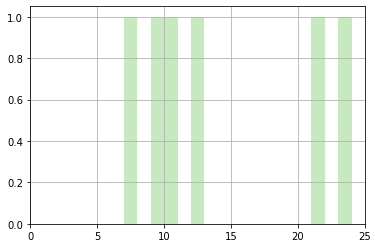

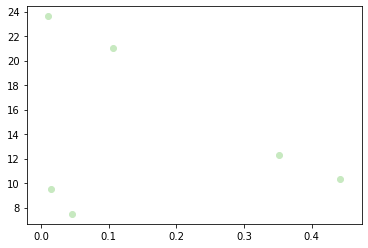

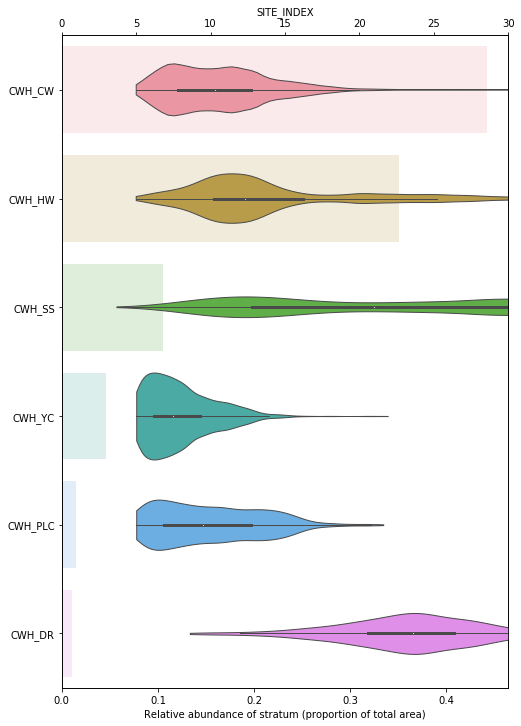

Pandas Apply:   0%|          | 0/65021 [00:00<?, ?it/s]

compiling stratum CWH_CW
compiling stratum CWH_HW
compiling stratum CWH_SS
compiling stratum CWH_YC
compiling stratum CWH_PLC
compiling stratum CWH_DR
CWH_CW
   L max_vol too low 113.02621962525461 <function <lambda> at 0x7f6413f07700>
   M max_vol too low 225.96580001717757 <function <lambda> at 0x7f6413f07700>
   H 3000
    median SI (VRI)                13.0
    median SI (siteprod)           18.0
    median SI ratio (VRI/siteprod)  0.72
    species CW   62
    species HW   38

CWH_HW


/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]


   L max_vol too low 218.30803388519155 <function <lambda> at 0x7f6413f07700>
   M 2001
    median SI (VRI)                12.0
    median SI (siteprod)           23.6
    median SI ratio (VRI/siteprod)  0.51
    species HW   66
    species SS   19
    species CW   15

   H 3001
    median SI (VRI)                20.8
    median SI (siteprod)           24.1
    median SI ratio (VRI/siteprod)  0.86
    species HW   72
    species SS   28

CWH_SS


/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]


   L 1002
    median SI (VRI)                12.0
    median SI (siteprod)           27.8
    median SI ratio (VRI/siteprod)  0.43
    species SS   74
    species HW   26

   M 2002
    median SI (VRI)                22.2
    median SI (siteprod)           28.0
    median SI ratio (VRI/siteprod)  0.79
    species SS   73
    species HW   27


/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]



   H 3002
    median SI (VRI)                31.3
    median SI (siteprod)           28.6
    median SI ratio (VRI/siteprod)  1.09
    species SS   77
    species HW   23

CWH_YC
   L max_vol too low 55.54514801693093 <function <lambda> at 0x7f6413f07700>
   M max_vol too low 117.21827625486999 <function <lambda> at 0x7f6413f07700>
   H max_vol too low 202.96070242490447 <function <lambda> at 0x7f6413f07700>
CWH_PLC
   L max_vol too low 83.15044268106608 <function <lambda> at 0x7f6413f07700>
   M max_vol too low 157.30424834638703 <function <lambda> at 0x7f6413f07700>
   H max_vol too low 227.4088714661065 <function <lambda> at 0x7f6413f07700>
CWH_DR
   L max_vol too low 263.13012994563917 <function <lambda> at 0x7f6413f07700>
   M bad leading species DR
   H bad leading species DR
25 3000
25 2001
25 3001
25 1002
25 2002
25 3002


/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]
/tmp/ipykernel_97122/1648795593.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level']).loc[sc, si_level]


In [142]:
if 1:
    force_run_vdyp = 0
    for tsa in ria_tsas[:]:
        stratum_col = 'stratum'
        %run 01a_run-tsa.ipynb

In [40]:
if 1:
    pickle.dump(vdyp_out_cache, open('vdyp_out_cache.pkl', 'wb'))

Pause running notebook and head to a Windows machine to run `02_input-tsa*.dat` files through BatchTIPSY, then copy `04_output-tsa*.out` files to `./data/`. But you could meet column problems. In this case, please check the column and compared with others. You may need to delete a space in following column: PCT_3, PCT_4. Also, you may need to add a space in following column: BEC, SI, GW_1, GW_age_1, GW_2, GW_age_2.

We tried to get TIPSY to run on a linux VM under Wine, but there is no way to run the software other than clicking through the GUI (yuck). We still might be able to get TIPSY fully automated, but this would require some sort of robot mouse click automation that we have not had time to figure out yet.

Loop over TSAs and run notebook `01b_run-tsa`. This compiles output data from TIPSY, and plots results on top of smoothed VDYP output (for visual inspection of AU-wise unmanaged+managed curve pairs, to confirm that projected yields are reasonable before proceeding).

0 21002
21002 CWH_SS L
1 22001
22001 CWH_HW M


/tmp/ipykernel_97122/1894421201.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[sc, si_level].set_index('age').volume.plot(label='VDYP')
/tmp/ipykernel_97122/1894421201.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[sc, si_level].set_index('age').volume.plot(label='VDYP')


2 22002
22002 CWH_SS M
3 23000
23000 CWH_CW H


/tmp/ipykernel_97122/1894421201.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[sc, si_level].set_index('age').volume.plot(label='VDYP')
/tmp/ipykernel_97122/1894421201.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[sc, si_level].set_index('age').volume.plot(label='VDYP')


4 23001
23001 CWH_HW H
5 23002
23002 CWH_SS H


/tmp/ipykernel_97122/1894421201.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[sc, si_level].set_index('age').volume.plot(label='VDYP')
/tmp/ipykernel_97122/1894421201.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[sc, si_level].set_index('age').volume.plot(label='VDYP')


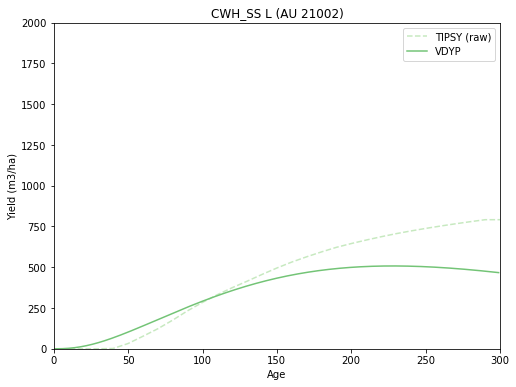

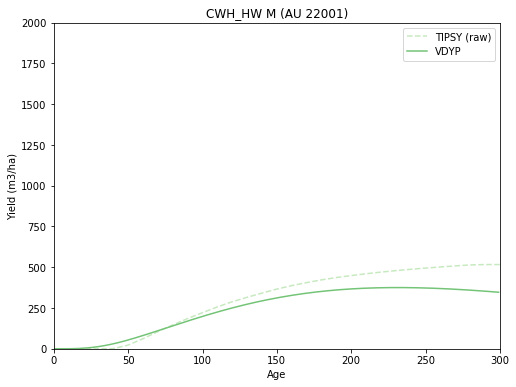

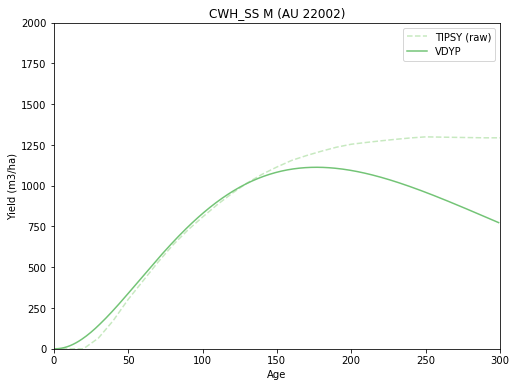

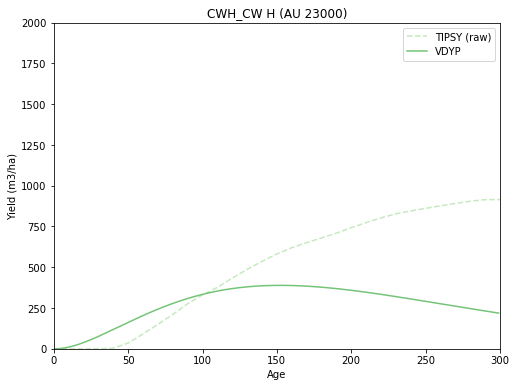

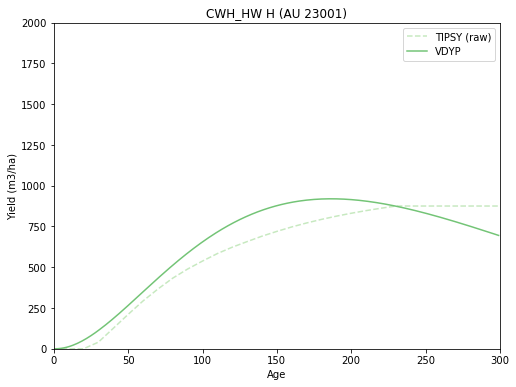

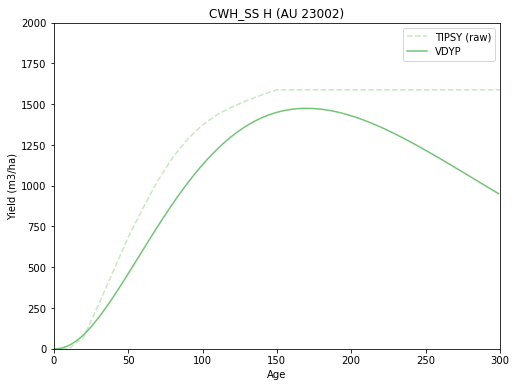

In [114]:
# loop over tsas here and run notebook 01_run-tsa_step2
for tsa in ria_tsas[:]:
    %run 01b_run-tsa.ipynb

Done.

# Export curves to CSV data tables (for soft-link to `spadesCBM`)

Failed attempt to automate translating VRI species codes to CANFI species codes. Could potentially work later, if the `LandR_sppEquivalencies.csv` data table was set up correctly to allow this. 

In [42]:
if 0:
    spp_map = pd.read_csv('./data/LandR_sppEquivalencies.csv')
    spp_map = spp_map[(~spp_map['LANDIS_traits'].isnull()) & (~spp_map['BC_Forestry'].isnull())][['BC_Forestry', 'LANDIS_traits']]
    spp_map['vri'] = spp_map['BC_Forestry'].str.upper()
    spp_map['link'] = spp_map['LANDIS_traits']
    canfi = pd.read_csv('./data/canfi_species.csv')
    canfi['link'] = canfi.genus + '.' + canfi.species
    canfi = canfi.set_index('link').merge(spp_map[['link', 'vri']], on='link', how='left')
    canfi = canfi[~canfi.vri.isnull()].set_index('vri')

Define a dict mapping VRI species codes to CANFI species codes (`spadesCBM` uses CANFI species codes), and a function that returns CANFI code for leading species given a stratum code. Reference: chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://www.for.gov.bc.ca/hfd/library/documents/bib106168.pdfchrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://www.for.gov.bc.ca/hfd/library/documents/bib106168.pdf

In [63]:
canfi_map = {'AC':1211, 
             'AT':1201, 
             'BL':304, 
             'EP':1303, 
             'FDI':500, 
             'HW':402, 
             'PL':204, 
             'PLI':204, 
             'SB':101, 
             'SE':104, 
             'SW':105, 
             'SX':100,
             'S':100,
             'CW':702,
             'SS':106,
             'YC':1001,
             'PLC':204,
             'DR':1802}

In [64]:
def canfi_species(stratum_code):
    s = stratum_code.split('_')[-1].split('+')[0]
    result = canfi_map[s]
    return result

Define some empty data structures to store output, and compile three data tables that will be used to import yield curve data into `spadesCBM`.

In [65]:
au_table_data = {'au_id':[],
                 'tsa':[],
                 'stratum_code':[],
                 'si_level':[],
                 'canfi_species':[],
                 'unmanaged_curve_id':[],
                 'managed_curve_id':[]} 

curve_table_data = {'curve_id':[],
                    'curve_type':[]}

curve_points_table_data = {'curve_id':[],
                           'x':[],
                           'y':[]}

for tsa in ria_tsas:
    print(tsa)
    vdyp_curves_ = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level'])
    tipsy_curves_ = tipsy_curves[tsa].reset_index().set_index('AU')
    for stratum_code, si_level in list(vdyp_curves_.index.unique()):
        au_id_ = scsi_au[tsa][(stratum_code, si_level)]
        tipsy_curve_id = 20000 + au_id_
        is_managed_au = tipsy_curve_id in tipsy_curves_.index.unique()
        au_id = 100000 * int(tsa) + au_id_
        unmanaged_curve_id = au_id
        managed_curve_id = au_id + 20000 if is_managed_au else unmanaged_curve_id
        #print(au_id, stratum_code, si_level, is_managed_au, unmanaged_curve_id, managed_curve_id)
        au_table_data['au_id'].append(au_id)
        au_table_data['tsa'].append(tsa)
        au_table_data['stratum_code'].append(stratum_code)
        au_table_data['si_level'].append(si_level)
        au_table_data['canfi_species'].append(canfi_species(stratum_code))
        au_table_data['unmanaged_curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_type'].append('unmanaged')
        vdyp_curve = vdyp_curves_.loc[(stratum_code, si_level)]
        #print('vdyp curve')
        for x, y in zip(vdyp_curve.age, vdyp_curve.volume):
            #print(x, round(y, 2))
            curve_points_table_data['curve_id'].append(unmanaged_curve_id)
            curve_points_table_data['x'].append(int(x))
            curve_points_table_data['y'].append(round(y, 2))
        au_table_data['managed_curve_id'].append(managed_curve_id)
        if is_managed_au:
            curve_table_data['curve_id'].append(managed_curve_id)
            curve_table_data['curve_type'].append('managed')        
            tipsy_curve = tipsy_curves_.loc[tipsy_curve_id]
            #print('tipsy curve')
            for x, y in zip(tipsy_curve.Age, tipsy_curve.Yield):
                #print(x, round(y, 2))
                curve_points_table_data['curve_id'].append(managed_curve_id)
                curve_points_table_data['x'].append(int(x))
                curve_points_table_data['y'].append(round(y, 2))
au_table = pd.DataFrame(au_table_data)
curve_table = pd.DataFrame(curve_table_data)
curve_points_table = pd.DataFrame(curve_points_table_data)

25


/tmp/ipykernel_97122/3762989976.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  vdyp_curve = vdyp_curves_.loc[(stratum_code, si_level)]


Display the first few lines of each table (quick sanity check).

In [66]:
au_table.head()

,au_id,tsa,stratum_code,si_level,canfi_species,unmanaged_curve_id,managed_curve_id
0,2501000,25,CWH_CW,L,702,2501000,2501000
1,2502000,25,CWH_CW,M,702,2502000,2502000
2,2503000,25,CWH_CW,H,702,2503000,2523000
3,2501001,25,CWH_HW,L,402,2501001,2501001
4,2502001,25,CWH_HW,M,402,2502001,2522001


In [67]:
curve_table.head()

,curve_id,curve_type
0,2501000,unmanaged
1,2502000,unmanaged
2,2503000,unmanaged
3,2523000,managed
4,2501001,unmanaged


In [68]:
curve_points_table.head()

,curve_id,x,y
0,2501000,9,0.0
1,2501000,10,0.0
2,2501000,11,0.0
3,2501000,12,0.0
4,2501000,13,0.0


Export tables to CSV for soft-link with `spadesCBM`.

In [69]:
au_table.to_csv('./data/spadescbm_bundle/au_table.csv')
curve_table.to_csv('./data/spadescbm_bundle/curve_table.csv')
curve_points_table.to_csv('./data/spadescbm_bundle/curve_points_table.csv')

# Impute THLB status to VRI stands

In this next section we impute timber harvesting landbase (THLB) status to the VRI stands. 

The process may seem very complex (because it is), however this is to _only_ (therefore simplest) procedure we were able to develop that comes close to matching TSA-wise THLB area reported in timber supply review (TSR) documentation published on the BC government web site.

If we had access to the original inventory datasets used in the TSR process, we could potentially just lift the THLB attribute from that. Alternatively, we could potentially rebuild the THLB "from the ground up" for each TSA by attempting to replicate THLB netdown documented in TSR documentation (neither trivial nor guaranteed to yield the "correct" THLB area).

Our method may be a bit messy, but it is robust insofar as we were able to get it to work for five TSAs (albeit with quite a bit of trial-and-error parameter tuning for certain TSAs).

Restore the VRI dataset from checkpoint 1, and filter records to include only the forested features to which we want to impute an AU and managment status.

In [70]:
f = gpd.read_feather(ria_vri_vclr1p_checkpoint1_feather_path)

We found a [THLB raster data layer]:(https://www.hectaresbc.org/app/habc/HaBC.html?type=raster&query=misc.thlb) on the [Hectares BC]:(https://hectaresbc.ca/app/habc/HaBC.html) web site (1 ha pixels). This website is maintained by the BC government (so we assume that data made available there is legitimate), however there is no metadata provided with the THLB raster data layer (so we cannot confirm the date it was compile, author, methodology, etc).

The first step in the process is to calculate stand-wise mean THLB (by masking the THLB raster data layer with stand polygons to extract the relevant pixels, and calculating mean value of all pixels with non-null values), and store the result in the `thlb_raw` field in the inventory dataframe. Note that THLB raster pixels.

Note that non-null data values in the THLB raster layer are in the range $[0, 100]$, which we are assuming as "percent attribution to THLB status". THLB should logically be a binary variable (not a percent), seeing as stands either are or are not eligible for harvesting. Perhaps the raster data is recompiled from a binary THLB attribute in a high-resolution polygon data layer with small sub-pixel areas netted out of THLB for various reasons (impossible to say from limited metadata). In later steps, we need to coerce this into a stand-wise binary THLB attribute to be compatible with `spades_ws3` module downstream.

Extract from THLB raster layer metadata follows, in case this helps track down some of the missing answers later.

<blockquote>
    
Description
The timber harvesting land base (THLB) is defined for timber supply analysis. The THLB is Crown forest land where timber harvesting is considered acceptable and economically feasible given objectives for all relevant forest values, existing timber quality, market values and available technology. It approximates the areas on which timber harvesting can reasonably be expected or extrapolated given existing forest management objectives and practices. The THLB is not meant to be a legally-defined or geographically static entity.

Creator / Publisher
Ministry of Forests and Range, Forest Analysis and Inventory Branch

Contact
Doug Layden (Doug.Layden@gov.bc.ca, Timber Supply Analyst, Ministry of Forests and Range, Forest Analysis and Inventory Branch

Load Date
April 13, 2011

Coverage
Timber Supply Areas. Not Tree Farm Licences.
</blockquote>

In [71]:
with rio.open('./data/misc.thlb.tif') as src:
    def mean_thlb(r):
        try:
            a, _ = mask(src, r.geometry, crop=True)
        except:
            return 0
        return np.mean(a[a >= 0])
    f['thlb_raw'] = f.swifter.apply(mean_thlb, axis=1)

Pandas Apply:   0%|          | 0/84898 [00:00<?, ?it/s]

/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


This is from an earlier (failed) attempt to impute a binary THLB attribute to VRI data directly from a data layer from a previous (PICS BC forest carbon) project. No dice (runs, but resulting TSA-wise THLB area does not match THLB area reported in TSR documentation).

In [72]:
if 0:
    thlb_rasterprop_thresh = 0.01
    with rio.open('./data/ria_demo/ria_landscapestack_init.tif') as src:
        def is_thlb(r):
            try:
                a, _ = mask(src, r.geometry, crop=True)
            except:
                return 0
            aa = a[1]
            return 1 if np.mean(aa[aa >= 0]) > thlb_rasterprop_thresh else 0
        f['thlb'] = f.swifter.apply(is_thlb, axis=1)

Filter VRI data.

In [73]:
if 1:
    f = f[f.BCLCS_LEVEL_2 == 'T'] # implies f.BCLCS_LEVEL_1 == 'V'
    #f = f[f.NON_PRODUCTIVE_CD != None]
    f = f[f.FOR_MGMT_LAND_BASE_IND == 'Y']
    f = f[~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])]
    f = f[~f.SPECIES_CD_1.isnull()]
    f = f[~f.BCLCS_LEVEL_5.isnull()]
    f = f[~f.SITE_INDEX.isnull()]

Check row and column count.

In [74]:
f.shape

(69847, 195)

Compile standard and lexmatch stratum fields.

In [75]:
f['BEC_ZONE_CODE_lexmatch'] = f.BEC_ZONE_CODE.str.ljust(4, fillchar='x')
for i in range(1, 3):
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str.ljust(4, 'x')
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str[:1] + f['SPECIES_CD_%i' % i]

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

f['stratum'] = f.swifter.apply(stratify_stand, axis=1)
f['stratum_lexmatch'] = f.swifter.apply(stratify_stand_lexmatch, axis=1)

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

In [76]:
f.to_feather(ria_vri_vclr1p_checkpoint5_feather_path)

In [77]:
if 0:
    f = pd.read_feather(ria_vri_vclr1p_checkpoint5_feather_path)

In [78]:
stratum_col = 'stratum'
f['%s_matched' % stratum_col] = None

In [79]:
if 0:
    au_table = pd.read_csv('./data/spadescbm_bundle/au_table.csv')
    curve_table = pd.read_csv('./data/spadescbm_bundle/curve_table.csv')
    curve_points_table = pd.read_csv('./data/spadescbm_bundle/curve_points_table.csv')
    au_table['tsa'] = au_table.apply(lambda r: '%02d' % r.tsa, axis=1
                                )

Compile `stratum_matched` column.

For stands in one of the compiled strata in each TSA (and filtered records that happen to have a stratum code in the list of compiled strata), we just use that stratum code (easy peasy). For the remaining records, we use the "best match" stratum code (which we derive from a lexicographic analysis that defines best match based on minimum Levenstein distance between the "lexmatch" versions of the stratum codes).   

In [80]:
for tsa in ria_tsas:    
    print('matching tsa', tsa)
    try:
        f.reset_index(inplace=True)
    except:
        pass
    stratum_codes = list(au_table.set_index('tsa').loc[tsa].stratum_code.unique())
    f_ = f.set_index('tsa_code').loc[tsa].set_index('stratum')
    totalarea = f_.FEATURE_AREA_SQM.sum()
    f_['totalarea_p'] = f_.FEATURE_AREA_SQM / totalarea
    names1 = set(f_.loc[stratum_codes].stratum_lexmatch.unique())
    names2 = set(f_.stratum_lexmatch.unique()) - names1
    stratum_key = f_.reset_index().groupby('%s_lexmatch' % stratum_col)[stratum_col].first()
    totalarea_p_sum__ = f_.groupby('%s_lexmatch' % stratum_col).totalarea_p.sum()
    lev_dist = {n2:{n1:distance.levenshtein(n1, n2) for n1 in names1} for n2 in names2}
    lev_dist_low = {n2:{n1:(lev_dist[n2][n1], totalarea_p_sum__.loc[n1]) 
                        for n1 in lev_dist[n2].keys() if lev_dist[n2][n1] == min(lev_dist[n2].values())} 
                    for n2 in names2}
    bm = {stratum_key.loc[n2]:stratum_key[max(lev_dist_low[n2].items(), key=operator.itemgetter(1))[0]] for n2 in names2}
    f_.reset_index(inplace=True)
    c, sc = stratum_col, stratum_codes
    f_['%s_matched' % stratum_col] = f_.swifter.apply(lambda r: r[c] if r[c] in sc else bm[r[c]], axis=1)
    
    m = f[['FEATURE_ID']].merge(f_[['FEATURE_ID', 'stratum_matched']], on='FEATURE_ID', how='left').set_index('FEATURE_ID')
    f.set_index('FEATURE_ID', inplace=True)
    f['stratum_matched'] = m.stratum_matched.where(~m.stratum_matched.isnull(), 
                                                   f.stratum_matched)

matching tsa 25


Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

Compile a dataframe of stratum-wise site index (SI) statistics, and then use this to assign `si_level` (H, M, L) attribute to each stand, based on stratum-level SI quantiles.

In [81]:
stratum_si_stats = f.groupby('stratum_matched').SITE_INDEX.describe(percentiles=[0, 0.05, 0.20, 0.35, 0.5, 0.65, 0.80, 0.95, 1])
#si_levelquants={'L':[5, 20, 35], 'M':[35, 50, 65], 'H':[65, 80, 95]}
si_levelquants={'L':[0, 20, 35], 'M':[35, 50, 65], 'H':[65, 80, 100]}

In [82]:
for stratum_code in stratum_si_stats.index:
    print(stratum_code)
    for i, (si_level, Q) in enumerate(si_levelquants.items()):        
        si_lo = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[0]]
        si_md = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[1]]
        si_hi = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[2]] 
        f.loc[(f.stratum_matched == stratum_code) & (f.SITE_INDEX >= si_lo) & (f.SITE_INDEX <= si_hi), 'si_level'] = si_level

CWH_CW
CWH_DR
CWH_HW
CWH_PLC
CWH_SS
CWH_YC


Assign an AU identifier code to each inventory record.

In [83]:
def au_from_scsi(r):
    try:
        au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
        return au_id
    except:
        return None

In [84]:
f['au'] = f.swifter.apply(au_from_scsi, axis=1)

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

Check dataframe shape.

In [85]:
f.shape

(69847, 203)

Filter out records with null AU.

In [86]:
f = f[~f.au.isnull()]

Check dataframe shape.

In [87]:
f.shape

(69847, 203)

Serialize dataframe to feather file.

In [88]:
f.to_feather(ria_vri_vclr1p_checkpoint6_feather_path)

In [89]:
try:
    au_table.set_index('au_id', inplace=True)
except:
    pass

Compile two new columns assigning a yield curve ID to each inventory record. 

`curve1` uses managed (TIPSY) curves if applicable (i.e., if age is 60 or less and has a managed yield curve defined). 
`curve2` only uses unmanaged (VDYP) yield curves.

In [90]:
def assign_curve1(r):
    # age=60 managed/unmanaged cutoff assumption from Cosmin Man (personal communication)
    au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
    au = au_table.loc[au_id]
    if r.PROJ_AGE_1 <= 60 and not np.isnan(au['managed_curve_id']):
        curve_id = au['managed_curve_id']
    else:
        curve_id = au['unmanaged_curve_id']
    return int(curve_id)

In [91]:
f['curve1'] = f.swifter.apply(assign_curve1, axis=1)

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

In [92]:
def assign_curve2(r):
    au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
    au = au_table.loc[au_id]
    return au['unmanaged_curve_id']

In [93]:
f['curve2'] = f.swifter.apply(assign_curve2, axis=1)

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

In [94]:
f.to_feather(ria_vri_vclr1p_checkpoint7_feather_path)

In [95]:
if 1:
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint7_feather_path) 

In [96]:
f.thlb_raw.describe()

count    48977.000000
mean        10.885128
std         23.188871
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         84.000000
Name: thlb_raw, dtype: float64

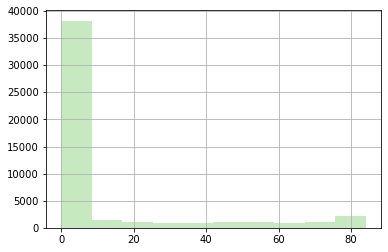

In [97]:
f.thlb_raw.hist()

In [98]:
f.reset_index(inplace=True)

In [99]:
def thlb_area(r):
    if r.tsa_code == '25':
        if r.thlb_raw < 90: 
            return 0.
        if r.SPECIES_CD_1 in species_spruce and r.SITE_INDEX < 10:
            return 0.
        if r.SPECIES_CD_1 in species_pine and r.SITE_INDEX < 15:
            return 0.
        if r.SPECIES_CD_1 in species_aspen and r.SITE_INDEX < 15:
            return 0.
        if r.SPECIES_CD_1 in species_fir and r.SITE_INDEX < 10:
            return 0.
        if r.SPECIES_CD_1 in ('SB', 'E', 'EA', 'EB', 'LT'):
            return 0
    return r.thlb_raw * r.FEATURE_AREA_SQM * 0.000001 

In [100]:
f['thlb_area'] = f.swifter.apply(thlb_area, axis=1)

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

In [101]:
def assign_thlb(r):
    thlb_thresh = 50
    if r.tsa_code == '08':
        thlb_thresh = 93
    #elif r.tsa_code == '25'
        #thlb_thresh = 
    elif r.tsa_code == '24':
        thlb_thresh = 69
    return 1 if r.thlb_raw > thlb_thresh else 0

In [102]:
f['thlb'] = f.swifter.apply(assign_thlb, axis=1)

Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

In [103]:
f.query('thlb == 1').groupby('tsa_code').FEATURE_AREA_SQM.sum() * 0.0001 
# Target number of thlb 77,893

tsa_code
25    82908.54465
Name: FEATURE_AREA_SQM, dtype: float64

In [104]:
f.groupby('tsa_code').thlb_area.sum() 

tsa_code
25    80917.243354
Name: thlb_area, dtype: float64

In [105]:
def has_managed_curve(r):
    if r.thlb == 0: 
        return -1
    else:
        if np.isnan(au_table.loc[int(r.au)].managed_curve_id):
            return 0
        else:
            return 1

In [106]:
f.to_feather(ria_vri_vclr1p_checkpoint8_feather_path)

In [107]:
if 0:
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint8_feather_path) 

In [108]:
if 0:
    f.to_file('./data/ria_vri-final.shp')
    !zip ./data/ria_vri-final_shp.zip ./data/ria_vri-final.*
    !mv ./data/ria_vri-final_shp.zip ./data/spadescbm_bundle/
    !zip -r ./data/spadescbm_bundle.zip ./data/spadescbm_bundle

In [109]:
def clean_geometry(r):
    from shapely.geometry import MultiPolygon
    g = r.geometry
    if not g.is_valid:
        _g = g.buffer(0)
        ################################
        # HACK
        # Something changed (maybe in fiona?) and now all GDB datasets are
        # loading as MultiPolygon geometry type (instead of Polygon). 
        # The buffer(0) trick smashes the geometry back to Polygon, 
        # so this hack upcasts it back to MultiPolygon.
        # 
        # Not sure how robust this is going to be (guessing not robust).
        _g = MultiPolygon([_g])
        assert _g.is_valid
        assert _g.geom_type == 'MultiPolygon'
        g = _g
    return g

In [110]:
def extract_features(f, tsa):
    f_ = f[['geometry', 'tsa_code', 'thlb', 'au', 'curve1', 'curve2', 'SPECIES_CD_1', 'PROJ_AGE_1', 'FEATURE_AREA_SQM']]
    f_ = f_.set_index('tsa_code').loc[tsa].reset_index()
    f_.geometry = f_.swifter.apply(clean_geometry, axis=1)
    return f_

In [111]:
#prop_names = [u'tsa_code', u'thlb', u'au', u'SPECIES_CD_1', u'PROJ_AGE_1', u'FEATURE_AREA_SQM']
prop_names = [u'tsa_code', u'thlb', u'au', u'canfi_species', u'PROJ_AGE_1', u'FEATURE_AREA_SQM']
prop_types = [(u'theme0', 'str:10'),
              (u'theme1', 'str:1'),
              (u'theme2', 'str:10'), 
              (u'theme3', 'str:5'), 
              (u'age', 'int:5'), 
              (u'area', 'float:10.1')]

In [112]:
columns = dict(zip(prop_names, dict(prop_types).keys()))

In [116]:
import os
for tsa in ria_tsas[:]:
    print('processing tsa', tsa)
    f_ = extract_features(f, tsa)
    try:
        os.mkdir('./data/shp/tsa%s.shp' % tsa)
    except:
        pass
    f_.rename(columns=columns, inplace=True)
    f_.theme0 = 'tsa' + f_.theme0
    f_.theme2 = f_.theme2.astype(int)
    f_.theme3 = f_.apply(lambda r: au_table.loc[r.theme2].canfi_species, axis=1)
    f_.age = f_.age.fillna(0)
    f_.age = f_.age.astype(int)
    f_.area = (f_.area * 0.0001).round(1)
    f_.to_file('./data/shp/tsa%s.shp/stands.shp' % tsa)

processing tsa 25


Pandas Apply:   0%|          | 0/69847 [00:00<?, ?it/s]

/opt/jupyterhub/lib/python3.8/site-packages/geopandas/geodataframe.py:199: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)
/tmp/ipykernel_97122/3828468149.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  f_.to_file('./data/shp/tsa%s.shp/stands.shp' % tsa)
